In [1]:
from mytorch.loss import CrossEntropyLoss
from mytorch.optim import Adam
from mytorch.dataloader import Dataloader
import numpy as np
import random
import pickle
from model import Model
from matplotlib import pyplot as plt

In [2]:
class Dataset:
    def __init__(self, img, target, transform=None):
        self.img = img
        self.target = target
        self.transform = transform
    
    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        if self.transform:
            img = self.transform(images = img.astype(np.uint8))
        img = (img-img.min())/img.max()
        target = self.target[idx]
        target = target*0.9+0.1/15.
        return img, target

In [3]:
def random_split(data, target, length):
    indices = list(range(len(data)))
    random.shuffle(indices)
    train_len = int(len(data)*length)
    val_len = len(data)-train_len
    train_data = [data[indices[i]] for i in range(train_len)]
    train_target = [target[indices[i]] for i in range(train_len)]
    val_data = [data[indices[i]] for i in range(train_len, train_len+val_len)]
    val_target = [target[indices[i]] for i in range(train_len, train_len+val_len)]
    return train_data, train_target, val_data, val_target

In [4]:
def accuracy(pred, target):
    y = np.argmax(pred.a, axis=1)
    t = np.argmax(target.a, axis=1)
    count = np.where(y == t, 1, 0)
    count = np.sum(count)
    return count/len(pred.a)

In [5]:
epoch = 500
batch_size = 16
lr = 1e-2
train_length = 0.8
path = "./weights/"

In [6]:
import imgaug.augmenters as iaa
augseq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.03)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Affine(
    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    rotate=(-15, 15),
    shear=(-3, 3)
    ),
    ], random_order=True
)
model = Model()
celoss = CrossEntropyLoss()
optim = Adam(model.get_params(), lr=lr)

train_data = np.load("./1_data/train_data.npy")
train_label = np.load("./1_data/train_label.npy")
train_x, train_y, val_x, val_y = random_split(train_data, train_label, train_length)
train_dataset = Dataset(train_x, train_y, augseq)
val_dataset = Dataset(val_x, val_y)
dataloader = Dataloader(train_dataset, batch_size, True)
val_dataloader = Dataloader(val_dataset)
size = len(train_dataset)

In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for e in range(epoch):
    progress = 0
    model.train()
    t_ac = 0
    t_loss = 0
    i = 0
    for x, target in dataloader:
        i += 1
        progress += batch_size
        optim.zero_grad()
        for _ in range(10):
            y = model(x)
            loss = celoss(y, target)
            loss.backward()
        optim.step()
        bar = int(progress/size*40)
        t_ac += accuracy(y, target)
        t_loss += float(loss.a)
        print("\r{}/{}[{}]loss: {} accuracy: {}".format(e,epoch,"="*bar+"-"*(40-bar),t_loss/i, t_ac/i), end="")
        del loss
    t_ac /= i+1e-7
    t_loss /= i+1e-7
    v_ac = 0
    v_loss = 0
    i = 0
    model.eval()
    for val_x, val_y in val_dataloader:
        for _ in range(10):
            i += 1
            y = model(val_x)
            v_ac += accuracy(y, val_y)
            v_loss += float(celoss(y, val_y).a)
    v_ac /= i+1e-7
    v_loss /= i+1e-7
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accuracies.append(t_ac)
    val_accuracies.append(v_ac)
    print(f"\nloss: {t_loss}, val_loss: {v_loss}, accuracy: {t_ac}, val_accuracy: {v_ac}")
    if (e+1)%10 == 0:
        with open(path+f"{e}_weights{v_ac}.pkl", "wb") as f:
            pickle.dump(model.state_dict(), f)

0/500[========================================]loss: 1.8941363969518756 accuracy: 0.064583333333333346
loss: 1.8941363956891182, val_loss: 2.6426757890236927, accuracy: 0.06458333329027778, val_accuracy: 0.06567708326765626
1/500[========================================]loss: 1.8529959349869618 accuracy: 0.081666666666666676
loss: 1.8529959337516313, val_loss: 2.429096672962076, accuracy: 0.08166666661222223, val_accuracy: 0.07755208325578127
2/500[========================================]loss: 1.8366808442425993 accuracy: 0.09708333333333333
loss: 1.8366808430181456, val_loss: 2.833291890076864, accuracy: 0.09708333326861111, val_accuracy: 0.07036458326296877
3/500[========================================]loss: 1.8260971364130094 accuracy: 0.097595973154362422
loss: 1.8260971351956115, val_loss: 3.134393263862832, accuracy: 0.097499999935, val_accuracy: 0.07526041659140627
4/500[========================================]loss: 1.8149224683742728 accuracy: 0.11416666666666667
loss: 1.814

37/500[========================================]loss: 0.9325259215070435 accuracy: 0.7887506040268457
loss: 0.9325259208853596, val_loss: 1.5845255265747749, accuracy: 0.7887499994741667, val_accuracy: 0.7199479159467188
38/500[========================================]loss: 0.9130746247783442 accuracy: 0.8054166666666667
loss: 0.9130746241696279, val_loss: 1.7049909788265398, accuracy: 0.8054166661297223, val_accuracy: 0.680624999319375
39/500[========================================]loss: 0.9497737078390587 accuracy: 0.8045833333333333
loss: 0.9497737072058762, val_loss: 2.8558507398029875, accuracy: 0.8045833327969445, val_accuracy: 0.6180208327153126
40/500[========================================]loss: 0.9098899128976189 accuracy: 0.8091666666666667
loss: 0.9098899122910256, val_loss: 2.2778681479719602, accuracy: 0.8091666661272222, val_accuracy: 0.6408854160257812
41/500[========================================]loss: 0.8483209775375735 accuracy: 0.8308333333333333
loss: 0.8483209

74/500[========================================]loss: 0.7142073587308664 accuracy: 0.9104166666666667
loss: 0.7142073582547283, val_loss: 1.4882108322849685, accuracy: 0.9104166660597223, val_accuracy: 0.7817187492182814
75/500[========================================]loss: 0.78266613682744 accuracy: 0.900416666666666676
loss: 0.7826661363056626, val_loss: 1.1560827890692065, accuracy: 0.9004166660663889, val_accuracy: 0.8127083325206251
76/500[========================================]loss: 0.6839607402167566 accuracy: 0.9154166666666667
loss: 0.6839607397607828, val_loss: 1.4265811838330458, accuracy: 0.9154166660563889, val_accuracy: 0.7998437492001566
77/500[========================================]loss: 0.7019587894425116 accuracy: 0.9112527516778524
loss: 0.7019587889745391, val_loss: 1.4222799359416431, accuracy: 0.9112499993925001, val_accuracy: 0.8059895825273438
78/500[========================================]loss: 0.7498585201787701 accuracy: 0.9125516778523493
loss: 0.749858

111/500[========================================]loss: 0.5808802994340554 accuracy: 0.9541666666666667
loss: 0.5808802990468019, val_loss: 0.6623590048380219, accuracy: 0.9541666660305556, val_accuracy: 0.919947915746719
112/500[========================================]loss: 0.5711316157407822 accuracy: 0.9608333333333333
loss: 0.5711316153600278, val_loss: 0.6847807833066675, accuracy: 0.9608333326927778, val_accuracy: 0.9150520824182814
113/500[========================================]loss: 0.5658315683558766 accuracy: 0.9697315436241611
loss: 0.5658315679786555, val_loss: 0.7871227251852562, accuracy: 0.95999999936, val_accuracy: 0.9006249990993752
114/500[========================================]loss: 0.5726879321209334 accuracy: 0.9570833333333333
loss: 0.5726879317391415, val_loss: 0.6978550778202164, accuracy: 0.9570833326952778, val_accuracy: 0.9086979157579689
115/500[========================================]loss: 0.5658697313884766 accuracy: 0.9579166666666666
loss: 0.5658697

148/500[========================================]loss: 0.5267464515369056 accuracy: 0.9775879194630873
loss: 0.5267464511857414, val_loss: 0.6751633609670271, accuracy: 0.9774999993483334, val_accuracy: 0.934374999065625
149/500[========================================]loss: 0.52597403645878 accuracy: 0.977916666666666793
loss: 0.5259740361081308, val_loss: 0.6690610771165008, accuracy: 0.9779166660147223, val_accuracy: 0.933072915733594
150/500[========================================]loss: 0.5246487782539746 accuracy: 0.9898657718120806
loss: 0.5246487779042088, val_loss: 0.635840716605811, accuracy: 0.9799999993466667, val_accuracy: 0.9361458323971875
151/500[========================================]loss: 0.5261174486542994 accuracy: 0.9770833333333333
loss: 0.5261174483035546, val_loss: 0.6120253542100124, accuracy: 0.9770833326819445, val_accuracy: 0.9468749990531251
152/500[========================================]loss: 0.5214630242747194 accuracy: 0.9829166666666667
loss: 0.5214

185/500[========================================]loss: 0.5011765738176299 accuracy: 0.99125127516778535
loss: 0.5011765734835123, val_loss: 0.6058106027233318, accuracy: 0.9912499993391667, val_accuracy: 0.9514062490485935
186/500[========================================]loss: 0.5051411153836559 accuracy: 0.98625181208053752
loss: 0.5051411150468952, val_loss: 0.5706420826262322, accuracy: 0.9862499993425, val_accuracy: 0.9611458323721875
187/500[========================================]loss: 0.5089769567599883 accuracy: 0.9858333333333333
loss: 0.5089769564206703, val_loss: 0.6045011336189309, accuracy: 0.9858333326761112, val_accuracy: 0.9497395823835938
188/500[========================================]loss: 0.5063334535746609 accuracy: 0.98751610738255045
loss: 0.5063334532371052, val_loss: 0.6053419079270034, accuracy: 0.9874999993416667, val_accuracy: 0.9486458323846875
189/500[========================================]loss: 0.500264955857211 accuracy: 0.991259127516778531
loss: 0.

222/500[========================================]loss: 0.4947098772535754 accuracy: 0.99083333333333339
loss: 0.49470987692376883, val_loss: 0.6087052905212099, accuracy: 0.9908333326727778, val_accuracy: 0.9465624990534373
223/500[========================================]loss: 0.4913637108212585 accuracy: 0.99254496644295302
loss: 0.4913637104936827, val_loss: 0.5558101169097794, accuracy: 0.9924999993383333, val_accuracy: 0.9655208323678124
224/500[========================================]loss: 0.49407176129100794 accuracy: 0.9929166666666667
loss: 0.4940717609616268, val_loss: 0.5639467012593593, accuracy: 0.9929166660047223, val_accuracy: 0.9648958323684373
225/500[========================================]loss: 0.49455920960447725 accuracy: 0.9908333333333333
loss: 0.4945592092747711, val_loss: 0.5638718757779624, accuracy: 0.9908333326727778, val_accuracy: 0.9614583323718748
226/500[========================================]loss: 0.4944989241072717 accuracy: 0.99993288590604025
los

KeyboardInterrupt: 

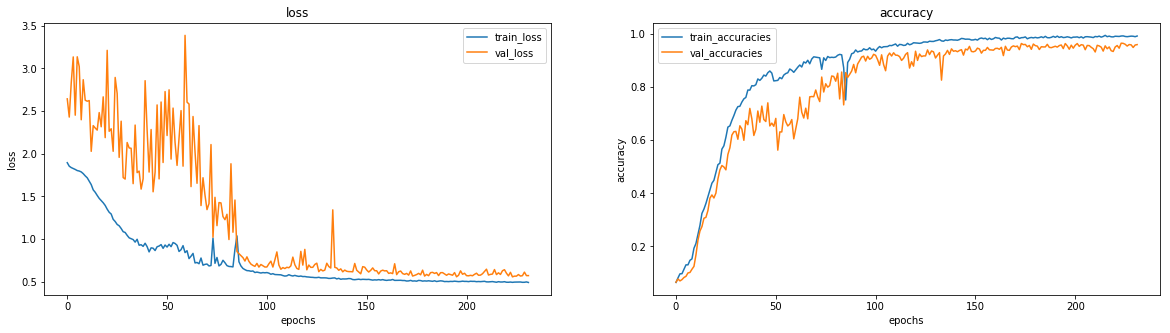

In [8]:
epochs = np.arange(len(train_losses))
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].plot(epochs, train_losses, label="train_loss")
ax[0].plot(epochs, val_losses, label="val_loss")
ax[0].legend()
ax[1].set_title("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].plot(epochs, train_accuracies, label="train_accuracies")
ax[1].plot(epochs, val_accuracies, label="val_accuracies")
ax[1].legend()
plt.show()

In [10]:
dataset = Dataset(train_data, train_label, augseq)
dataloader = Dataloader(train_dataset, batch_size, True)
size = len(train_dataset)
epoch = 50

for e in range(epoch):
    progress = 0
    model.train()
    t_ac = 0
    t_loss = 0
    i = 0
    for x, target in dataloader:
        i += 1
        progress += batch_size
        optim.zero_grad()
        for _ in range(10):
            y = model(x)
            loss = celoss(y, target)
            loss.backward()
        optim.step()
        bar = int(progress/size*40)
        t_ac += accuracy(y, target)
        t_loss += float(loss.a)
        print("\r{}/{}[{}]loss: {} accuracy: {}".format(e,epoch,"="*bar+"-"*(40-bar),t_loss/i, t_ac/i), end="")
        del loss
    if (e+1)%10 == 0:
        with open(path+f"epoch{e}_weights{t_ac}.pkl", "wb") as f:
            pickle.dump(model.state_dict(), f)

49/50[========================================]loss: 0.4854835477321286 accuracy: 0.99596644295302025